# Cat or Dog - Deep Learning

## Bibliotecas

In [49]:
import os
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Download dataset e criando as pastas (train e validation)

In [50]:
# URL of the dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Download the dataset
def download_dataset(url, filename):
    """
    Download the dataset from the given URL and save it to the specified filename.
    """
    try:
        urllib.request.urlretrieve(url, filename)
        print(f"Dataset downloaded and saved as {filename}")
    except Exception as e:
        print(f"Error downloading dataset: {e}")

# Extract the dataset
def extract_dataset(filename, extract_dir):
    """
    Extract the contents of the downloaded ZIP file to the specified directory.
    """
    try:
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Dataset extracted to {extract_dir}")
    except Exception as e:
        print(f"Error extracting dataset: {e}")

# Set the filename and extract directory
filename = 'cats_and_dogs.zip'
extract_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

# Create the extract directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Download and extract the dataset
download_dataset(_URL, filename)
extract_dataset(filename, extract_dir)


Dataset downloaded and saved as cats_and_dogs.zip
Dataset extracted to c:\Users\saulo\OneDrive\Documentos\cat_or_dog\cats_and_dogs_filtered


1. ***train_dir*** - Pasta contendo imagens para treinamento

In [51]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dir = 'cats_and_dogs_filtered/cats_and_dogs_filtered/train'

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


2. ***validation_dir*** - Pasta contendo imagens para validação

In [52]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

validation_dir = 'cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


### Algumas imagens da base de treinamento

- Nove imagens e rótulos do conjunto de treinamento:

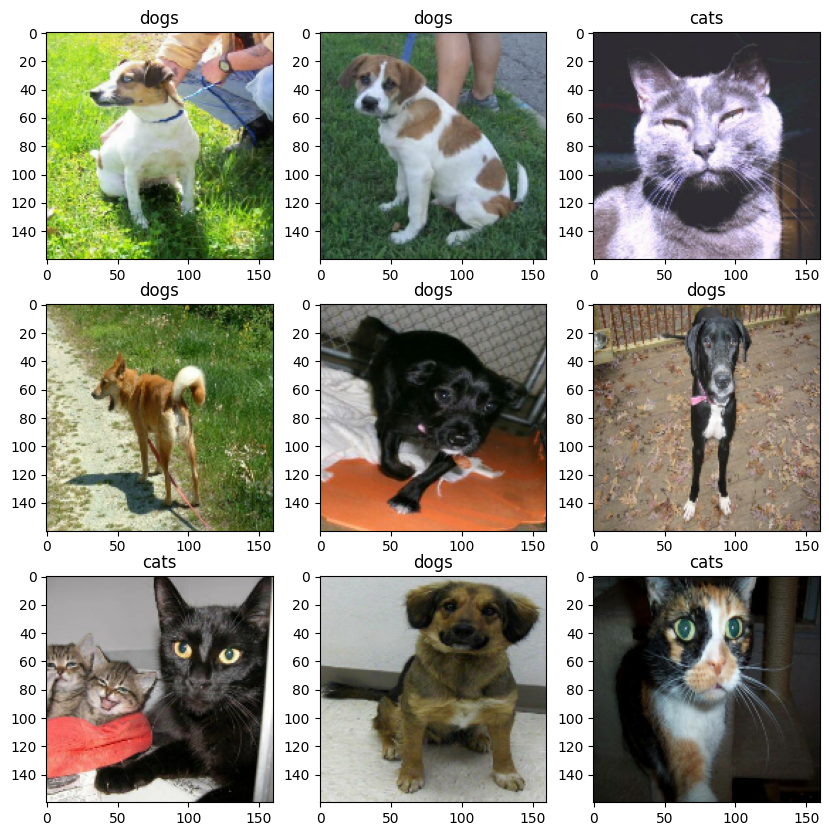

In [53]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")

Como o conjunto de dados original não contém um conjunto de teste, criaremos um.

Para fazer isso, determinei quantos lotes de dados estão disponíveis no conjunto de validação usando *tf.data.experimental.cardinality* e movi 20% deles para um conjunto de teste.

In [54]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [55]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Data augmentation

Faremos um *data augmentation* para aumentar a quantidade e a diversidade dos dados disponíveis para treinamento de um modelo.

Para isso criaremos uma variável que incluirá essa técnica nas camadas da CNN.

In [56]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Vamos ver como fica!

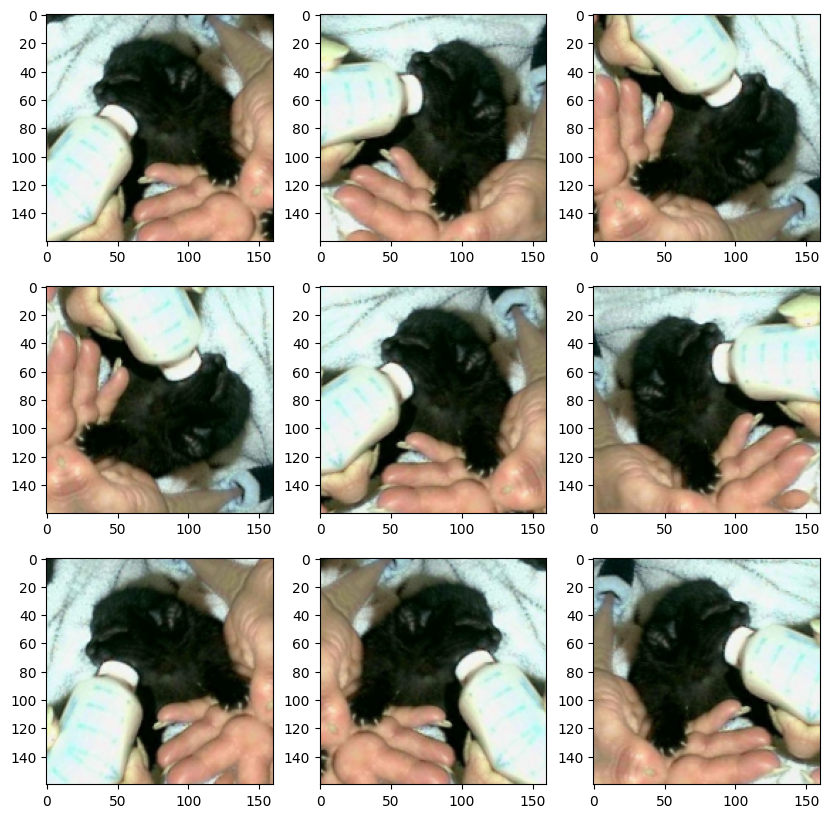

In [57]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        # display.reconstruct_image(first_image)
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255.0)
        plt.axis("on")  


### Modelagem - Aprendizado por transferência (*MobileNet V2*)

Desenvolvido pelo Google, o *MobileNet V2* consiste em um Rede Neural Convolucional projetada para ser eficiente em termos de uso de recursos computacionais, o que significa que é mais leve e consome menos energia do que muitos modelos convolucionais mais complexos.

O *MobileNet V2* espera imagens cujos pixels estão em valores entre -1 e 1. 

Como as imagens que serão utilizadas no treinamento estão entre 0 e 255, precisaremos redimensionar.

Para isso, usaremos o método de pré-processamento incluído no modelo (*tf.keras.applications.mobilenet_v2.preprocess_input*)

In [58]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Observação**: como alternativa, você pode redimensionar os valores de pixel de [0, 255] para [-1, 1] usando tf.keras.layers.Rescaling .

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Extraindo as camadas do *MobileNet V2*

1 - Carregar o modelo pré-treinado utilizando os pesos treinados na base do *imagenet*. 

Ao instanciar o modelo, o argumento *include_top=False* não inclui as camadas de classificação da parte superior da rede.

In [59]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # não incluí a camada de classificação (superior)
                                               weights='imagenet')

Em seguida usaremos um extrator de recursos para converter cada imagem de 160x160x3 em um bloco de recursos de 5x5x1280.

Vamos ver o que ele faz com um exemplo de lote de imagens:

In [60]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Extração de recursos

Nesta etapa, será congelada a base convolucional criada na etapa anterior e usará como extrator de recursos.

Além disso, será adicionado um classificador em cima dele e um treinamento do classificador de nível superior.

#### Congele a base convolucional

É importante congelar a base convolucional antes de compilar e treinar o modelo.

O congelamento (definindo *layer.trainable = False*) evita que os pesos em uma determinada camada sejam atualizados durante o treinamento. 

O MobileNet V2 tem muitas camadas, portanto, definir o sinalizador trainable de todo o modelo como False irá congelar todas elas.

In [61]:
base_model.trainable = False

**Nota importante sobre camadas de BatchNormalization**

Muitos modelos contêm camadas tf.keras.layers.BatchNormalization. Essa camada é um caso especial e precauções devem ser tomadas no contexto do ajuste fino.

Quando você define *layer.trainable = False*, a camada *BatchNormalization* será executada no modo de inferência e não atualizará suas estatísticas de média e variação.

Quando você descongela um modelo que contém camadas *BatchNormalization* para fazer o ajuste fino, você deve manter as camadas BatchNormalization no modo de inferência passando *training = False* ao chamar o modelo base. 

**Caso contrário, as atualizações aplicadas aos pesos não treináveis ​​destruirão o que o modelo aprendeu.**

### Verificar a arquitetura do modelo

Resumidamente, a arquitetura do *MobileNet V2* utiliza várias técnicas para reduzir o número de operações computacionais e parâmetros, sem comprometer significativamente o desempenho.

Ele emprega camadas convolucionais profundas com blocos residuais e conexões lineares entre camadas não lineares para melhorar o fluxo de gradientes durante o treinamento.

In [62]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Adicionar um cabeçalho de classificação

Para gerar previsões a partir do bloco de feições, calcule a média das localizações espaciais 5x5, usando uma camada *tf.keras.layers.GlobalAveragePooling2D* para converter as feições em um único vetor de 1280 elementos por imagem.

In [63]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplique uma camada *tf.keras.layers.Dense* para converter esses recursos em uma única previsão por imagem.

Não é necessário uma função de ativação aqui porque essa previsão será tratada como um logit ou um valor bruto de previsão.

**Números positivos predizem a classe 1, números negativos predizem a classe 0.**

In [64]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Construa um modelo encadeando as camadas:

1. aumento de dados;

2. redimensionamento;

3. base_model e; 

4. extrator de recursos usando a API funcional do Keras. 

Como mencionado anteriormente, use *training=False* pois nosso modelo contém uma camada *BatchNormalization*.

In [65]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compilar o modelo

Compilar o modelo antes de treiná-lo.

Como existem duas classes, use a perda *tf.keras.losses.BinaryCrossentropy* com *from_logits=True*, pois o modelo fornece uma saída linear.

In [66]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Verificar o modelo final

In [67]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Os 2,5 milhões de parâmetros no *MobileNet V2* estão congelados, mas existem 1,2 mil parâmetros treináveis na camada *Dense*.

Estes são divididos entre dois objetos *tf.Variable*, os *pesos* e os *bias*.

In [68]:
len(model.trainable_variables)

2

### Treinar o modelo

Vamos treinar 10 épocas, como o tutorial sugere.

Após treinar por 10 épocas, devemos ter ~94% de precisão no conjunto de validação.

In [70]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.2758 - loss: 1.0820


In [71]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.09
initial accuracy: 0.27


#### Extrair a loss e accuracy para realizar a curva de aprendizagem.

In [72]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.4011 - loss: 0.9558 - val_accuracy: 0.5644 - val_loss: 0.7108
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.5755 - loss: 0.6914 - val_accuracy: 0.7364 - val_loss: 0.5145
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 276ms/step - accuracy: 0.7044 - loss: 0.5348 - val_accuracy: 0.8106 - val_loss: 0.3908
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - accuracy: 0.7881 - loss: 0.4321 - val_accuracy: 0.8552 - val_loss: 0.3121
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - accuracy: 0.8286 - loss: 0.3767 - val_accuracy: 0.8787 - val_loss: 0.2567
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.8538 - loss: 0.3288 - val_accuracy: 0.9035 - val_loss: 0.2196
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - accuracy: 0.8602 - loss: 0.2992 - val_accuracy: 0.9158 - val_loss: 0.1898
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.8780 - loss: 0.2732 - val_accu

### Curvas de aprendizado

Vamos dar uma olhada nas curvas de aprendizado da accuracy/loss do treinamento e validação ao usar o modelo base *MobileNetV2* como um extrator de recursos fixo.

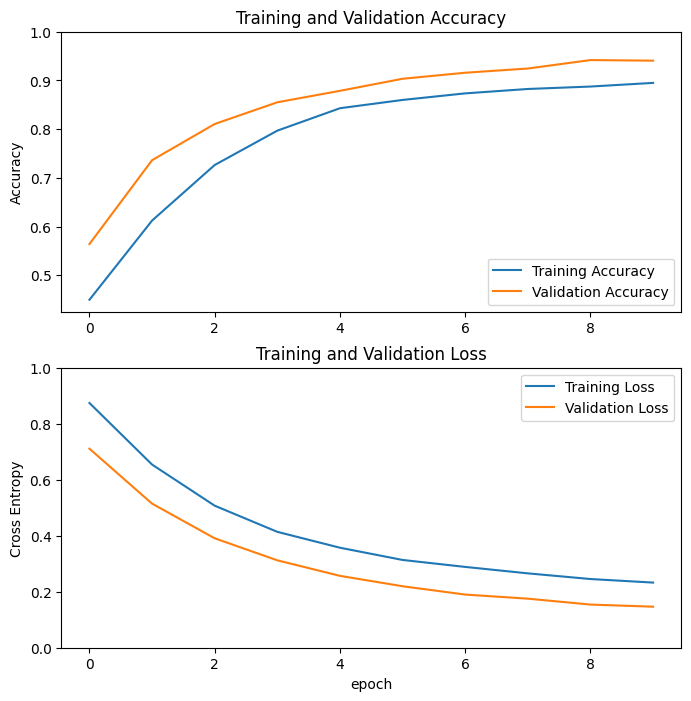

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Nota**: Por que as métricas de validação são claramente melhores do que as métricas de treinamento?

O principal fator é porque camadas como *tf.keras.layers.BatchNormalization* e *tf.keras.layers.Dropout* afetam a precisão durante o treinamento. Eles são desativados ao calcular a perda de validação.

Em menor grau, também é porque as métricas de treinamento relatam a média de uma época, enquanto as métricas de validação são avaliadas após a época, portanto, as métricas de validação veem um modelo que foi treinado um pouco mais.


Link para o ipynb
https://www.tensorflow.org/tutorials/images/transfer_learning?hl=pt-br#data_download